## Imporerer pakker

In [40]:
import pandas as pd
import numpy as np



# Model Selection and Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error, r2_score, accuracy_score, f1_score, log_loss, confusion_matrix

from sklearn.compose import TransformedTargetRegressor

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor


# Classification Models
from sklearn.linear_model import LogisticRegression, HuberRegressor, BayesianRidge, LassoLars, PassiveAggressiveRegressor, TheilSenRegressor, SGDRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# Other Model Utilities
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import plot_tree

from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import make_scorer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import matplotlib.pyplot as plt
from sklearn import set_config
import plotly.express as px
from sklearn.compose import TransformedTargetRegressor
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.compose import TransformedTargetRegressor
from scipy import stats
from xgboost import XGBRegressor
from sklearn.preprocessing import TargetEncoder
import shap
from sklearn.preprocessing import MinMaxScaler
import pickle

## Laster inn filer

In [41]:
train_df = pd.read_csv('train_df.csv')
val_df = pd.read_csv('validation_df.csv')
test_df = pd.read_csv('test_df.csv')

pd.set_option('display.max_columns', None)
pd.reset_option('display.float_format')

## Variabelutvinning

In [42]:
train_df

,oppholdslengde,alder,kjønn,utdanning,inntekt,etnisitet,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde,sykdomskategori,sykdom_underkategori,antall_komorbiditeter,koma_score,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,kreft,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,dnr_status
0,6,34.0,male,8.0,8.0,white,73.0,9.000000,120.0,32.0,36.29688,333.30000,3.199707,1.299805,135.0,NaN,95.0,23.00,2025.0,Cancer,Lung Cancer,3,0.0,3.0,25.000000,14.0,0.613892,0.297974,0,0,metastatic,0.80,0.50,NaN
1,49,43.0,male,9.0,8.0,black,127.0,28.097656,154.0,36.0,36.09375,226.65625,4.299805,0.699951,138.0,7.439453,NaN,6.51,2502.0,ARF/MOSF,ARF/MOSF w/Sepsis,1,9.0,NaN,29.898438,48.0,0.698975,0.608887,0,0,no,NaN,NaN,NaN
2,3,58.0,male,10.0,35.0,black,107.0,30.597656,131.0,28.0,36.39844,371.37500,1.799805,1.099854,130.0,7.449219,146.0,32.00,2284.0,COPD/CHF/Cirrhosis,COPD,5,0.0,NaN,14.199219,21.0,0.931885,0.884888,0,0,no,NaN,NaN,NaN
3,13,76.0,female,16.0,8.0,white,85.0,7.099609,92.0,20.0,36.39844,338.06250,2.799805,1.699951,132.0,7.489258,NaN,6.51,2502.0,COPD/CHF/Cirrhosis,Cirrhosis,3,0.0,NaN,21.097656,31.0,0.656982,0.479980,1,0,no,1.00,1.00,NaN
4,4,81.0,male,6.0,NaN,white,43.0,21.699219,104.0,36.0,35.59375,168.31250,2.699707,0.500000,143.0,7.399414,149.0,18.00,805.0,ARF/MOSF,ARF/MOSF w/Sepsis,2,37.0,5.0,31.000000,40.0,0.417969,0.298950,0,0,no,0.25,0.10,dnr ved innleggelse
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3983,5,59.0,male,NaN,NaN,white,105.0,7.500000,69.0,16.0,36.39844,333.30000,3.799805,0.799927,137.0,NaN,NaN,6.51,2502.0,Cancer,Lung Cancer,1,0.0,NaN,11.500000,13.0,0.811890,0.596924,0,0,metastatic,NaN,NaN,NaN
3984,18,71.0,female,15.0,35.0,white,138.0,22.500000,110.0,40.0,36.39844,242.84375,2.500000,0.399963,123.0,7.429688,147.0,13.00,1980.0,ARF/MOSF,MOSF w/Malig,1,9.0,0.0,18.898438,33.0,0.664917,0.567993,0,0,metastatic,0.80,0.60,NaN
3985,11,58.0,female,14.0,20.0,white,53.0,8.898438,96.0,33.0,35.79688,136.71875,2.599609,1.899902,138.0,7.419922,187.0,41.00,1855.0,ARF/MOSF,MOSF w/Malig,1,0.0,0.0,18.796875,9.0,0.748901,0.669922,0,0,metastatic,0.90,0.50,NaN
3986,16,69.0,male,NaN,NaN,white,133.0,13.699219,128.0,36.0,39.29688,276.00000,3.500000,0.899902,134.0,7.489258,NaN,6.51,2502.0,Cancer,Colon Cancer,1,0.0,NaN,28.597656,50.0,0.580933,0.260986,0,0,metastatic,NaN,NaN,NaN


In [43]:
train_df['etnisitet'].value_counts()

etnisitet
white       3173
black        598
hispanic     134
other         45
asian         28
Name: count, dtype: int64

In [44]:
from preprocessing import prepare_data_for_prediction
from preprocessing import categorical_cols
from preprocessing import numeric_cols
from preprocessing import col_transformer
import importlib
import preprocessing

# Tving gjeninnlasting av modulen
importlib.reload(preprocessing)


X_train, numeric_cols_train, categorical_cols_train, y_train = prepare_data_for_prediction(train_df, prediction_mode=False)
X_val, numeric_cols_val, categorical_cols_val, y_val = prepare_data_for_prediction(val_df, prediction_mode=False)
X_test, numeric_cols_test, categorical_cols_test, y_test = prepare_data_for_prediction(test_df, prediction_mode=False)

In [45]:
X_train

,alder,kjønn,utdanning,inntekt,etnisitet,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde,sykdomskategori,sykdom_underkategori,antall_komorbiditeter,koma_score,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,kreft,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,dnr_status,alvorlighetsgrad_høy,alvorlighetsgrad_lav,alvorlighetsgrad_middels,alder_fysiologisk_interaction,age_binned
0,34.0,male,8.0,8.0,white,73.0,9.000000,120.0,32.0,36.29688,333.30000,3.199707,1.299805,135.0,NaN,95.0,23.00,2025.0,Cancer,Lung Cancer,3,0.0,3.0,25.000000,14.0,0.613892,0.297974,0,0,metastatic,0.80,0.50,NaN,False,False,True,850.000000,middle-aged
1,43.0,male,9.0,8.0,black,127.0,28.097656,154.0,36.0,36.09375,226.65625,4.299805,0.699951,138.0,7.439453,NaN,6.51,2502.0,ARF/MOSF,ARF/MOSF w/Sepsis,1,9.0,NaN,29.898438,48.0,0.698975,0.608887,0,0,no,NaN,NaN,NaN,False,False,True,1285.632812,middle-aged
2,58.0,male,10.0,35.0,black,107.0,30.597656,131.0,28.0,36.39844,371.37500,1.799805,1.099854,130.0,7.449219,146.0,32.00,2284.0,COPD/CHF/Cirrhosis,COPD,5,0.0,NaN,14.199219,21.0,0.931885,0.884888,0,0,no,NaN,NaN,NaN,False,False,True,823.554690,middle-aged
3,76.0,female,16.0,8.0,white,85.0,7.099609,92.0,20.0,36.39844,338.06250,2.799805,1.699951,132.0,7.489258,NaN,6.51,2502.0,COPD/CHF/Cirrhosis,Cirrhosis,3,0.0,NaN,21.097656,31.0,0.656982,0.479980,1,0,no,1.00,1.00,NaN,False,False,True,1603.421871,senior
4,81.0,male,6.0,NaN,white,43.0,21.699219,104.0,36.0,35.59375,168.31250,2.699707,0.500000,143.0,7.399414,149.0,18.00,805.0,ARF/MOSF,ARF/MOSF w/Sepsis,2,37.0,5.0,31.000000,40.0,0.417969,0.298950,0,0,no,0.25,0.10,dnr ved innleggelse,False,False,True,2511.000000,senior
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3983,59.0,male,NaN,NaN,white,105.0,7.500000,69.0,16.0,36.39844,333.30000,3.799805,0.799927,137.0,NaN,NaN,6.51,2502.0,Cancer,Lung Cancer,1,0.0,NaN,11.500000,13.0,0.811890,0.596924,0,0,metastatic,NaN,NaN,NaN,False,False,True,678.500000,middle-aged
3984,71.0,female,15.0,35.0,white,138.0,22.500000,110.0,40.0,36.39844,242.84375,2.500000,0.399963,123.0,7.429688,147.0,13.00,1980.0,ARF/MOSF,MOSF w/Malig,1,9.0,0.0,18.898438,33.0,0.664917,0.567993,0,0,metastatic,0.80,0.60,NaN,False,False,True,1341.789062,senior
3985,58.0,female,14.0,20.0,white,53.0,8.898438,96.0,33.0,35.79688,136.71875,2.599609,1.899902,138.0,7.419922,187.0,41.00,1855.0,ARF/MOSF,MOSF w/Malig,1,0.0,0.0,18.796875,9.0,0.748901,0.669922,0,0,metastatic,0.90,0.50,NaN,False,False,True,1090.218750,middle-aged
3986,69.0,male,NaN,NaN,white,133.0,13.699219,128.0,36.0,39.29688,276.00000,3.500000,0.899902,134.0,7.489258,NaN,6.51,2502.0,Cancer,Colon Cancer,1,0.0,NaN,28.597656,50.0,0.580933,0.260986,0,0,metastatic,NaN,NaN,NaN,False,False,True,1973.238278,senior


In [46]:
from preprocessing import col_transformer

X_train_imputed = col_transformer.fit_transform(X_train)
X_val_imputed = col_transformer.transform(X_val)
X_test_imputed = col_transformer.transform(X_test)

numeric_feature_names = numeric_cols
# Extract the one-hot encoded categorical feature names
categorical_feature_names = col_transformer.named_transformers_['cat_pipeline']\
    .named_steps['one-hot-encoder'].get_feature_names_out(categorical_cols)

# Combine the feature names
feature_names = list(numeric_feature_names) + list(categorical_feature_names)

X_train_imputed = pd.DataFrame(X_train_imputed, columns=feature_names)
X_val_imputed = pd.DataFrame(X_val_imputed, columns=feature_names)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=feature_names)

## Grunnlinjemodeller

In [47]:
baseline = DummyRegressor(strategy='mean')
baseline.fit(X_train, y_train)
prediction = baseline.predict(X_val)
rmse_baseline = root_mean_squared_error(y_val, prediction)
rmse_baseline

20.28080085106761

In [48]:
baseline2 = DummyRegressor(strategy='median')
baseline2.fit(X_train, y_train)
prediction = baseline2.predict(X_val)
rmse_baseline = root_mean_squared_error(y_val, prediction)
rmse_baseline

21.234585052201545

## Modellering

## Visualisering av actual vs predicted

In [49]:
def plot_actual_vs_pred(y_actual, y_pred, model_name):
    df = pd.DataFrame({'Actual': y_actual, 'Predicted': y_pred})
    fig = px.scatter(df, x='Actual', y='Predicted', title=f"{model_name}: Actual vs. Predicted")
    fig.add_shape(type="line", x0=df['Actual'].min(), y0=df['Actual'].min(),
                  x1=df['Actual'].max(), y1=df['Actual'].max(), line=dict(color='Red', dash='dash'))
    fig.show()


## RandomForestRegression

In [50]:
model_rf = RandomForestRegressor(n_estimators=200, max_depth=50, random_state=42)
model_rf.fit(X_train_imputed, y_train)

# Evaluate the model on validation data
y_val_pred_rf = model_rf.predict(X_val_imputed)
rmse_val_rf = (root_mean_squared_error(y_val, y_val_pred_rf))
print(f"RMSE on Validation Set (RandomForest): {rmse_val_rf:.3f}")
plot_actual_vs_pred(y_val, y_val_pred_rf, "Random Forest with Target Encoding")

RMSE on Validation Set (RandomForest): 19.261


## ExtraTreesRegressor

In [51]:
# Define and train ExtraTrees model
model_et = ExtraTreesRegressor(n_estimators=200, random_state=42)
model_et.fit(X_train_imputed, y_train)

# Evaluate on validation data
y_val_pred_et = model_et.predict(X_val_imputed)
rmse_val_et = (root_mean_squared_error(y_val, y_val_pred_et))
print(f"RMSE on Validation Set (ExtraTrees): {rmse_val_et:.3f}")
plot_actual_vs_pred(y_val, y_val_pred_et, "Random Forest with Target Encoding")

RMSE on Validation Set (ExtraTrees): 19.119


## GradientBoostingRegressor

In [52]:
# Define and train ExtraTrees model
model_gb = GradientBoostingRegressor(n_estimators=200, random_state=42)
model_gb.fit(X_train_imputed, y_train)

# Evaluate on validation data
y_val_pred_gb = model_gb.predict(X_val_imputed)
rmse_val_gb = (root_mean_squared_error(y_val, y_val_pred_gb))
print(f"RMSE on Validation Set (ExtraTrees): {rmse_val_gb:.3f}")
plot_actual_vs_pred(y_val, y_val_pred_gb, "Random Forest with Target Encoding")

RMSE on Validation Set (ExtraTrees): 19.694


In [53]:
from sklearn.model_selection import RandomizedSearchCV

X_train_full = X_train_imputed
X_val_full = X_val_imputed

# Define the parameter grid for ExtraTreesRegressor
param_grid_et = {
    'n_estimators': [100, 200, 500],  # Number of trees
    'max_depth': [10, 20, 50, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],    # Minimum samples required to be at a leaf node
    'bootstrap': [True, False]        # Whether bootstrap samples are used when building trees
}

# Initialize RandomizedSearchCV for ExtraTreesRegressor
random_search_et = RandomizedSearchCV(
    estimator=ExtraTreesRegressor(random_state=42),
    param_distributions=param_grid_et,
    n_iter=50,  # Number of random parameter combinations to try
    cv=5,  # 5-fold cross-validation
    scoring='neg_root_mean_squared_error',
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit the random search model on the full feature set (X_train_full)
random_search_et.fit(X_train_full, y_train)

# Best hyperparameters
print(f"Best Hyperparameters: {random_search_et.best_params_}")

# Best RMSE score
best_rmse = -random_search_et.best_score_
print(f"Best RMSE Score: {best_rmse:.3f}")

# After finding the best model, use it to predict on the validation set
best_et_model = random_search_et.best_estimator_

# Predict on the validation set (with full features)
y_val_pred_best_et = best_et_model.predict(X_val_full)

# Calculate RMSE for the full feature set
rmse_best_et = root_mean_squared_error(y_val, y_val_pred_best_et)
print(f"RMSE on Validation Set with Full Features: {rmse_best_et:.3f}")

# Call the plot_actual_vs_pred function to visualize actual vs predicted values
plot_actual_vs_pred(y_val, y_val_pred_best_et, "Best ExtraTreesRegressor with Full Features")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   2.8s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   2.8s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   2.8s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.7s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.8s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.8s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.9s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators

In [54]:
from sklearn.model_selection import GridSearchCV

# Use the best parameters as the center of the grid
param_grid_et_refined = {
    'n_estimators': [150, 200, 250],  # Around 200
    'max_depth': [40, 50, 60],        # Around 50
    'min_samples_split': [8, 10, 12], # Around 10
    'min_samples_leaf': [3, 4, 5],    # Around 4
    'bootstrap': [True]               # Keep as True based on RandomizedSearch result
}

# Initialize GridSearchCV for ExtraTreesRegressor
grid_search_et = GridSearchCV(
    estimator=ExtraTreesRegressor(random_state=42),
    param_grid=param_grid_et_refined,
    cv=5,  # 5-fold cross-validation
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit the grid search model on the full feature set (X_train_full)
grid_search_et.fit(X_train_full, y_train)

# Best hyperparameters from GridSearch
print(f"Best Hyperparameters from GridSearch: {grid_search_et.best_params_}")

# Best RMSE score from GridSearch
best_rmse_grid = -grid_search_et.best_score_
print(f"Best RMSE Score from GridSearch: {best_rmse_grid:.3f}")

# After finding the best model, use it to predict on the validation set
best_et_model_grid = grid_search_et.best_estimator_

# Predict on the validation set (with full features)
y_val_pred_best_et_grid = best_et_model_grid.predict(X_val_full)

# Calculate RMSE for the full feature set
rmse_best_et_grid = root_mean_squared_error(y_val, y_val_pred_best_et_grid)
print(f"RMSE on Validation Set with Full Features (GridSearch): {rmse_best_et_grid:.3f}")

# Visualize actual vs predicted values
plot_actual_vs_pred(y_val, y_val_pred_best_et_grid, "Best ExtraTreesRegressor with Full Features (GridSearch)")



Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=150; total time=   3.8s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=150; total time=   3.8s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=150; total time=   3.8s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=150; total time=   3.8s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=150; total time=   3.9s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   5.5s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   5.6s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   5.7s
[C

In [55]:
with open('model.pkl', 'wb') as f:
    pickle.dump((best_et_model_grid, col_transformer, feature_names), f)

In [56]:
# Get feature importances from the best model after GridSearch
importances = best_et_model_grid.feature_importances_

# Create a DataFrame to display feature importances with the correct features
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,  # Use the feature names from X_train_full
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the top features
feature_importance_df.T


,36,15,18,14,16,17,8,13,0,4,10,19,6,5,12,2,3,32,7,46,11,41,1,35,9,48,47,26,22,20,25,31,50,21,28,23,51,34,38,24,37,43,29,39,42,49,33,44,40,45,30,27
Feature,sykdom_underkategori_ARF/MOSF w/Sepsis,apache_fysiologisk_score,lege_overlevelsesestimat_2mnd,fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,serumalbumin,koma_score,alder,hjertefrekvens,natrium,lege_overlevelsesestimat_6mnd,kroppstemperatur,respirasjonsfrekvens,antall_komorbiditeter,blodtrykk,hvite_blodlegemer,sykdomskategori_ARF/MOSF,lungefunksjon,inntekt_8.0,blod_ph,sykdom_underkategori_Coma,utdanning,sykdomskategori_Coma,kreatinin,inntekt_35.0,inntekt_20.0,kjønn_male,blodurea_nitrogen,diabetes,kjønn_female,etnisitet_white,kreft_no,glukose,etnisitet_black,urinmengde,kreft_yes,sykdomskategori_Cancer,sykdom_underkategori_COPD,demens,sykdom_underkategori_CHF,sykdom_underkategori_MOSF w/Malig,etnisitet_hispanic,sykdom_underkategori_Cirrhosis,sykdom_underkategori_Lung Cancer,kreft_metastatic,sykdomskategori_COPD/CHF/Cirrhosis,dnr_status_dnr før innleggelse,sykdom_underkategori_Colon Cancer,dnr_status_dnr ved innleggelse,etnisitet_other,etnisitet_asian
Importance,0.229515,0.058595,0.05125,0.046239,0.033837,0.032536,0.029904,0.029453,0.029345,0.024962,0.024734,0.024042,0.024018,0.023851,0.02342,0.023139,0.022305,0.01901,0.016287,0.015814,0.015334,0.015272,0.014886,0.014545,0.013263,0.012791,0.01265,0.012319,0.011699,0.011626,0.011429,0.011241,0.010475,0.009524,0.00864,0.006856,0.004378,0.00367,0.002723,0.002711,0.002701,0.002368,0.001783,0.001136,0.000808,0.000763,0.000701,0.0005,0.000406,0.000361,0.000118,0.000068


## Log-Transformasjon på target data

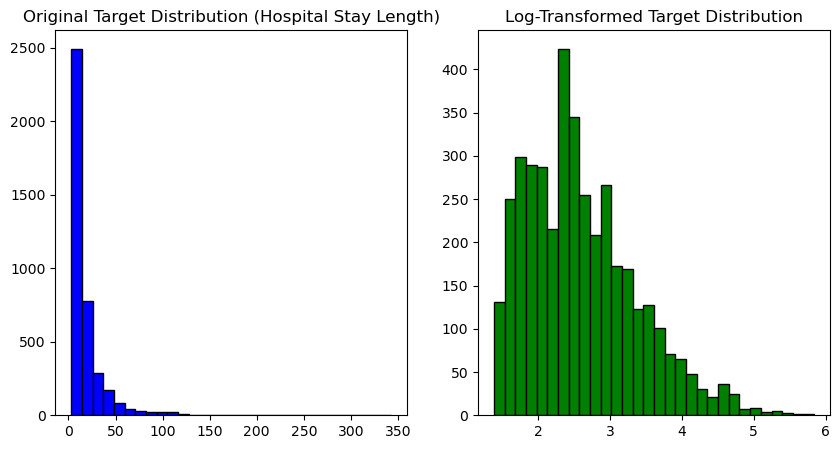

In [57]:
plt.figure(figsize=(10, 5))

# Histogram of original target values
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=30, color='blue', edgecolor='black')
plt.title('Original Target Distribution (Hospital Stay Length)')

# Histogram of log-transformed target values
plt.subplot(1, 2, 2)
plt.hist(np.log1p(y_train), bins=30, color='green', edgecolor='black')
plt.title('Log-Transformed Target Distribution')

plt.show()

In [58]:
# Log transformation of the target variable (log(1 + x) to handle zero values)
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

# Fit the best ExtraTrees model on the log-transformed target
best_et_model.fit(X_train_imputed, y_train_log)

# Predict on the validation set
pred_log = best_et_model.predict(X_val_imputed)

# Inverse transformation (exp to bring predictions back to original scale)
pred_original_scale = np.expm1(pred_log)

# Calculate RMSE on the original scale
rmse = (root_mean_squared_error(y_val, pred_original_scale))
print(f"RMSE with log transformation: {rmse:.3f}")

# Plot actual vs predicted values
plot_actual_vs_pred(y_val, pred_original_scale, "ExtraTrees with Log Transformation")


RMSE with log transformation: 18.227


## Forsøker å trene modellen på ved å fjerne ekstreme uteliggere med over 95% 

## TODO: Fortsette å teste med flere variable, eventuelt forsøke å fjerne noen. Analysere RMSE, for å finne ut hvorfor den er som den er. Er det mulig at modellen er god, men at den misser stort på uteliggere?